Implementing Random Forest Regression model

Estimate and plot different error metrics (RMSE, MSE, MAE, Average Error) in a 20 runs of a Random Forest Regression model. ***Each runs has a different 20/80 test training split, and with the stratified data***

The point is that the estimation could be done for two different set of bins and for mode with and without overfitting reduction. So, the point is that it is possible to check the difference in estimated errors according to different set of bins and also possible to have comparison between reducedoverfitting model and overfitting model.

In [7]:
#%load_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, max_error
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif,
)
from sklearn.preprocessing import RobustScaler
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import random
import pickle
import openpyxl
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import pickle
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#import geopandas as gpd
import importlib

wor_dir="/home/mforooshani/Typhoon-Impact-based-forecasting-model-training-5:7/IBF-Typhoon-model/"
os.chdir(wor_dir)
cdir = os.getcwd()

combined_input_data=pd.read_csv("Training-data-new/data/model_input/combined_input_data.csv")
#display(combined_input_data)

typhoons_with_impact_data=['bopha2012', 'conson2010', 'durian2006', 'fengshen2008',
       'fung-wong2014', 'goni2015', 'goni2020', 'hagupit2014',
       'haima2016', 'haiyan2013', 'jangmi2014', 'kalmaegi2014',
       'kammuri2019', 'ketsana2009', 'koppu2015', 'krosa2013',
       'linfa2015', 'lingling2014', 'mangkhut2018', 'mekkhala2015',
       'melor2015', 'meranti2016', 'molave2020', 'mujigae2015',
       'nakri2019', 'nari2013', 'nesat2011', 'nock-ten2016', 'noul2015',
       'phanfone2019', 'rammasun2014', 'sarika2016', 'saudel2020',
       'tokage2016', 'trami2013', 'usagi2013', 'utor2013', 'vamco2020',
       'vongfong2020', 'yutu2018']

len(np.unique(combined_input_data.typhoon))
combined_input_data=combined_input_data[combined_input_data.typhoon.isin(typhoons_with_impact_data)]


def set_zeros(x):
    x_max = 25
    y_max = 50
    
    v_max = x[0]
    rainfall_max = x[1]
    damage = x[2]
    if pd.notnull(damage):
        value = damage
    elif v_max > x_max or rainfall_max > y_max:
        value =damage
    elif (v_max < np.sqrt((1- (rainfall_max**2/y_max ** 2))*x_max ** 2)):
        value = 0
    #elif ((v_max < x_max)  and  (rainfall_max_6h < y_max) ):
    #elif (v_max < x_max ):
    #value = 0
    else:
        value = np.nan

    return value
combined_input_data["DAM_perc_dmg"] = combined_input_data[["HAZ_v_max", "HAZ_rainfall_Total", "DAM_perc_dmg"]].apply(set_zeros, axis="columns")


np.mean(combined_input_data["DAM_perc_dmg"])
combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
np.mean(combined_input_data["DAM_perc_dmg"])
np.unique(combined_input_data.typhoon)

def cubeic(x):
    #x=float(x)
    value=x*x*x
    return value

combined_input_data['HAZ_v_max_3']=combined_input_data['HAZ_v_max'].apply(lambda x: x*x*x) 


combined_input_data =combined_input_data.filter(['typhoon','HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary', 
        'DAM_perc_dmg'])


features_name = combined_input_data.columns
#display(features_name)


#Dropping highly correlated features which their correlation values are greater than 0.99.
features =['HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        #'GEN_Bu_p_inSSA', 
        #'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        #'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        #'TOP_mean_ruggedness',
        #'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary']


df=combined_input_data.dropna()
display(df)



,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,185.828571,14.716071,7.381696,55.032241,166667.757548,2.478142,2.64,6.18,6.18,...,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568
2,durian2006,8.818750,0.455208,0.255319,8.728380,664.968323,288.358553,0.06,0.00,0.00,...,0.850008,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000
4,durian2006,24.175000,2.408333,0.957639,10.945624,1311.358762,274.953818,1.52,1.28,1.28,...,0.197179,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000
6,durian2006,14.930000,1.650000,0.586250,12.108701,1775.385328,252.828578,0.00,0.00,0.00,...,0.279362,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000
7,durian2006,13.550000,1.054167,0.528125,10.660943,1211.676901,258.194381,5.52,0.36,0.36,...,0.065703,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,noul2015,9.700000,0.408333,0.216146,8.136932,538.743551,277.107823,1.80,6.25,6.25,...,0.186916,3.613707,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000
25837,noul2015,17.587500,1.414583,0.386458,9.818999,946.676507,305.789817,0.00,0.00,0.00,...,0.209059,0.383275,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000
25838,noul2015,11.487500,0.614583,0.230319,15.791907,3938.254316,210.313249,0.06,0.09,0.09,...,0.202748,0.090110,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000
25839,noul2015,11.600000,1.400000,0.412766,13.867145,2666.620370,218.189328,0.00,0.00,0.00,...,0.000000,0.094518,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000


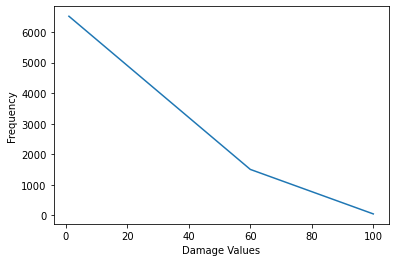

In [8]:
#The Old and New set of bins
bins2= [0, 1, 60, 100]
#bins2 = [0, 0.00009, 1, 10, 50, 100]
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [9]:
print(samples_per_bin2)
print(binsP2)

[6517 1506   50]
[  0   1  60 100]


In [10]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [11]:
y_input_strat=bin_index2

In [12]:
#the Beginning time to run the model 20 times
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-10-20 01:14:21


In [13]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statistics
# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

#Define empty lists for results
train_RMSE_list=[]
test_RMSE_list=[]

train_MSE_list=[]
test_MSE_list=[]

train_MAE_list=[]
test_MAE_list=[]

train_AVE_list=[]
test_AVE_list=[]

for i in range(20): 
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2)

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    #Random Forest before solution of Overfitting
    rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5)
    
    #Random Forest ReducedOverfitting
    #rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5, max_samples=0.7)
    
    rf_model=rf.fit(X_train, y_train)
    
    
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())

    
    y_pred_train = rf.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mx_train = max_error(y_train, y_pred_train)
    me_train = (y_pred_train - y_train).sum()/len(y_train)

    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mx = max_error(y_test, y_pred)
    me = (y_pred - y_test).sum()/len(y_test)

    print('----- Test  ------')
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    print(f'Max error: {mx:.2f}')
    print(f"Average Error: {me:.2f}")

    print('---- Training -----')
    print(f'Mean absolute error: {mae_train:.2f}')
    print(f'Mean squared error: {mse_train:.2f}')
    print(f'Root mean squared error: {rmse_train:.2f}')
    print(f'Max error: {mx_train:.2f}')
    print(f"Average Error: {me_train:.2f}")
   
    
    score = rf.score(X_train, y_train)  
    print("Training score coefficient of determination for Random Forest R^2: %.3f " % (score))
    
    test_RMSE_list.append(rmse)
    train_RMSE_list.append(rmse_train)
    
    test_MSE_list.append(mse)
    train_MSE_list.append(mse_train)
    
    test_MAE_list.append(mae)
    train_MAE_list.append(mae_train)
    
    test_AVE_list.append(me)
    train_AVE_list.append(me_train)
    
print(test_RMSE_list)    
print(train_RMSE_list) 

print(test_MSE_list)    
print(train_MSE_list) 

print(test_MAE_list)    
print(train_MAE_list)
    
    

Index(['HAZ_rainfall_Total', 'HAZ_rainfall_max_6h', 'HAZ_rainfall_max_24h',
       'HAZ_v_max', 'HAZ_v_max_3', 'HAZ_dis_track_min', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_Yel_per_LSSAb', 'GEN_OR_per_SSAbldg', 'GEN_Yellow_per_LSbl',
       'TOP_mean_slope', 'TOP_mean_elevation_m', 'TOP_ruggedness_stdev',
       'VUL_poverty_perc', 'GEN_with_coast', 'GEN_coast_length',
       'VUL_Housing_Units', 'VUL_StrongRoof_StrongWall',
       'VUL_StrongRoof_LightWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall',
       'VUL_vulnerable_groups', 'VUL_pantawid_pamilya_beneficiary'],
      dtype='object')

(6458, 31) (6458,)
(1615, 31) (1615,)
                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     202.4
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        01:14:30   Log-Likelihood:                -21269.
No. Observations:                6458   AIC:                         4.260e+04
Df Residuals:                    6426   BIC:                         4.282e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

In [14]:
#the End time of running the model 20 times
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-10-20 01:17:06


stdev_AVERAGE_test: 0.13
stdev_AVERAGE_train: 0.01
mean_AVERAGE_test: 0.04
mean_AVERAGE_train: 0.04


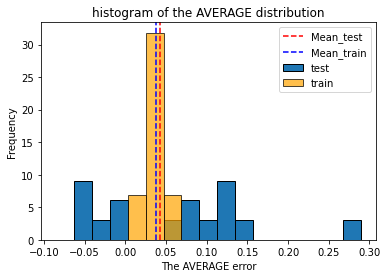

In [15]:
#Average Error

m_test_ave = statistics.mean(test_AVE_list)
plt.axvline(m_test_ave, color='red', linestyle='dashed')
plt.hist(test_AVE_list, bins=np.arange(-0.085,0.3,0.022), edgecolor='k', histtype ='bar', density=True)
sd_test_ave = statistics.stdev(test_AVE_list)

m_train_ave = statistics.mean(train_AVE_list)
plt.axvline(m_train_ave, color='b', linestyle='dashed')
plt.hist(train_AVE_list, color='orange', edgecolor='k', bins=np.arange(-0.085,0.3,0.022), histtype ='bar', density=True, alpha=0.7)
sd_train_ave = statistics.stdev(train_AVE_list)

print(f'stdev_AVERAGE_test: {sd_test_ave:.2f}')
print(f'stdev_AVERAGE_train: {sd_train_ave:.2f}')

print(f'mean_AVERAGE_test: {m_test_ave:.2f}')
print(f'mean_AVERAGE_train: {m_train_ave:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The AVERAGE error')
plt.ylabel('Frequency')
plt.title('histogram of the AVERAGE distribution')
plt.show()

stdev_MAE_test: 0.09
stdev_MAE_train: 0.03
mean_MAE_test: 1.90
mean_MAE_train: 1.22


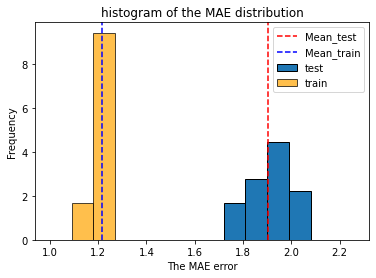

In [28]:
#MAE

m_test_mae = statistics.mean(test_MAE_list)
plt.axvline(m_test_mae, color='red', linestyle='dashed')
plt.hist(test_MAE_list, bins=np.arange(1.0,2.3,0.09), edgecolor='k', histtype ='bar', density=True)
sd_test_mae = statistics.stdev(test_MAE_list)
#plt.axvline(m+sd, color='b', linestyle='dashed')
#plt.axvline(m-sd, color='b', linestyle='dashed')


m_train_mae = statistics.mean(train_MAE_list)
plt.axvline(m_train_mae, color='b', linestyle='dashed')
plt.hist(train_MAE_list, color='orange', edgecolor='k', bins=np.arange(1.0,2.3,0.09), histtype ='bar', density=True, alpha=0.7)

sd_train_mae = statistics.stdev(train_MAE_list)
#plt.axvline(m+sd, color='y', linestyle='dashed')
#plt.axvline(m-sd, color='y', linestyle='dashed')

print(f'stdev_MAE_test: {sd_test_mae:.2f}')
print(f'stdev_MAE_train: {sd_train_mae:.2f}')

print(f'mean_MAE_test: {m_test_mae:.2f}')
print(f'mean_MAE_train: {m_train_mae:.2f}')


#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The MAE error')
plt.ylabel('Frequency')
plt.title('histogram of the MAE distribution')
plt.show()

stdev_RMSE_test: 0.40
stdev_RMSE_train: 0.10
mean_RMSE_test: 5.92
mean_RMSE_train: 4.01


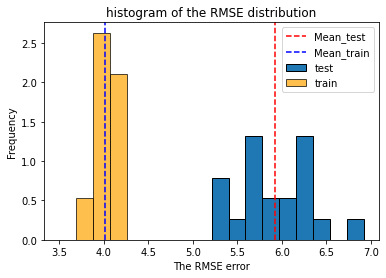

In [26]:
#RMSE

m_test_rmse = statistics.mean(test_RMSE_list)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list, bins=np.arange(3.5,7.0,0.19), #color='b',
         edgecolor='k', histtype ='bar', density=True, #alpha=0.5
        )
sd_test_rmse = statistics.stdev(test_RMSE_list)
#plt.axvline(m+sd, color='b', linestyle='dashed')
#plt.axvline(m-sd, color='b', linestyle='dashed')


m_train_rmse = statistics.mean(train_RMSE_list)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list, bins=np.arange(3.5,7.0,0.19), color='orange', edgecolor='k', histtype ='bar', density=True, alpha=0.7)

sd_train_rmse = statistics.stdev(train_RMSE_list)
#plt.axvline(m+sd, color='y', linestyle='dashed')
#plt.axvline(m-sd, color='y', linestyle='dashed')

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution')
plt.show()

stdev_MSE_test: 4.75
stdev_MSE_train: 0.77
mean_MSE_test: 35.18
mean_MSE_train: 16.13


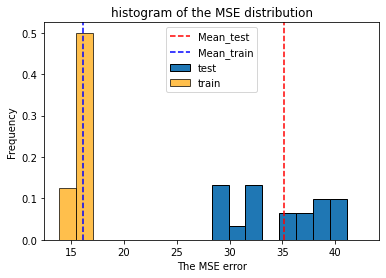

In [18]:
#MSE

m_test_mse = statistics.mean(test_MSE_list)
plt.axvline(m_test_mse, color='red', linestyle='dashed')
plt.hist(test_MSE_list, bins=np.arange(13.9,43.2,1.6), #color='b',
         edgecolor='k', histtype ='bar', density=True)

m_train_mse = statistics.mean(train_MSE_list)
plt.axvline(m_train_mse, color='b', linestyle='dashed')
plt.hist(train_MSE_list, color='orange', bins=np.arange(13.9,43.2,1.6), edgecolor='k', histtype ='bar', density=True, alpha=0.7)

sd_train_mse = statistics.stdev(train_MSE_list)
sd_test_mse = statistics.stdev(test_MSE_list)

print(f'stdev_MSE_test: {sd_test_mse:.2f}')
print(f'stdev_MSE_train: {sd_train_mse:.2f}')

print(f'mean_MSE_test: {m_test_mse:.2f}')
print(f'mean_MSE_train: {m_train_mse:.2f}')


#create legend
colors_2 = ["lime", "blue"]
labels_2= ["test","train"]
#plt.legend(labels_2)


#create legend
colors = ["tan", "red"]
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The MSE error')
plt.ylabel('Frequency')
plt.title('histogram of the MSE distribution')
plt.show()

In [19]:
###Codes in the following cells displays the estimated errors in a single run of Random Forest Regression Model.

In [20]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2) 


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


Index(['HAZ_rainfall_Total', 'HAZ_rainfall_max_6h', 'HAZ_rainfall_max_24h',
       'HAZ_v_max', 'HAZ_v_max_3', 'HAZ_dis_track_min', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_Yel_per_LSSAb', 'GEN_OR_per_SSAbldg', 'GEN_Yellow_per_LSbl',
       'TOP_mean_slope', 'TOP_mean_elevation_m', 'TOP_ruggedness_stdev',
       'VUL_poverty_perc', 'GEN_with_coast', 'GEN_coast_length',
       'VUL_Housing_Units', 'VUL_StrongRoof_StrongWall',
       'VUL_StrongRoof_LightWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall',
       'VUL_vulnerable_groups', 'VUL_pantawid_pamilya_beneficiary'],
      dtype='object')

(6458, 31) (6458,)
(1615, 31) (1615,)


In [21]:
# create an Random Forest regression model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5)

rf_model=rf.fit(X_train, y_train)

In [22]:
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     176.3
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        01:17:14   Log-Likelihood:                -21579.
No. Observations:                6458   AIC:                         4.322e+04
Df Residuals:                    6426   BIC:                         4.344e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4447      0.085     28.651      0.0

In [23]:
y_pred_train = rf.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mx_train = max_error(y_train, y_pred_train)
me_train = (y_pred_train - y_train).sum()/len(y_train)

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mx = max_error(y_test, y_pred)
me = (y_pred - y_test).sum()/len(y_test)

print('----- Test  ------')
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Max error: {mx:.2f}')
print(f"Average Error: {me:.2f}")

print('---- Training -----')
print(f'Mean absolute error: {mae_train:.2f}')
print(f'Mean squared error: {mse_train:.2f}')
print(f'Root mean squared error: {rmse_train:.2f}')
print(f'Max error: {mx_train:.2f}')
print(f"Average Error: {me_train:.2f}")

----- Test  ------
Mean absolute error: 1.74
Mean squared error: 29.75
Root mean squared error: 5.45
Max error: 72.14
Average Error: 0.17
---- Training -----
Mean absolute error: 1.24
Mean squared error: 16.44
Root mean squared error: 4.05
Max error: 74.83
Average Error: 0.04


In [24]:
score = rf.score(X_train, y_train)  
print("Training score coefficient of determination for Random Forest R^2: %.3f " % (score))

Training score coefficient of determination for Random Forest R^2: 0.810 
